In [2]:
import torch
from torch_geometric.data import Data


edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
edge_weight = torch.tensor([1, 1, 0, 0])
train_mask = torch.tensor([True, False, False])
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, train_mask=train_mask)

In [3]:
# function that maps (64, 192, 192) -> [0, 2359295]
shape = (48, 48, 48)
def volume_to_graph(i,j,k, shape=shape):
    z, y, x = shape
    return k + y * j + y * x * i

def graph_to_volume(idx, shape=shape):
    z, y, x = shape
    i, r = divmod(idx, y * x)
    j, k = divmod(r, y)
    return (i,j,k)

def correct_edge(i,j,k, shape=shape):
    z, y, x = shape
    return (0 <= i < z) and (0 <= j < y) and (0 <= k < x)

In [4]:
volume_to_graph(0, 1, 2, shape=shape)
graph_to_volume(2)

(0, 0, 2)

In [5]:
graph_to_volume(volume_to_graph(21, 1, 50, shape=shape), shape=shape)

(21, 2, 2)

In [6]:
x = -1
for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            assert graph_to_volume(volume_to_graph(i,j,k, shape=shape), shape=shape) == (i,j,k)
            assert correct_edge(i,j,k, shape=shape)
print("done !")

done !


In [120]:
3/64

0.046875

In [119]:
7 / 192

0.036458333333333336

In [138]:
from math import exp

sigma = 0.04
edge_index0 = []
edge_index1 = []
edge_weight = []
for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            new_edges = [(i, j+1, k), (i, j, k+1), (i, j-1, k), (i, j, k-1), 
                            #(i, j+2, k), (i, j, k+2), (i, j-2, k), (i, j, k-2), 
                            #(i, j+1, k+1), (i, j-1, k+1), (i, j-1, k+1), (i, j-1, k-1), 
                            (i-1, j, k), (i+1, j, k)]
            new_edges_weight = 4*[exp(-(7/192)**2 / (2 *sigma**2))] + 2*[exp(-(3/64)**2 / (2 *sigma**2))] # + 4*[exp(-(0.3**2 + 0.3**2) / (2 *sigma**2))] + 2*[exp(-0.7**2 / (2 *sigma**2))]
            
            current_v = volume_to_graph(i,j,k)
            for coord, weight in zip(new_edges, new_edges_weight):
                if correct_edge(*coord):
                    edge_index0.append(current_v)
                    edge_index1.append(volume_to_graph(*coord))
                    edge_weight.append(weight)


In [139]:
shape[0] * shape[1] * shape[2] * 14 - 2*shape[1]*shape[2] - 2*(shape[1] + shape[2])*shape[0] - (2*(shape[1] + shape[2])*4 - 4)*shape[0]

1497792

In [140]:
len(edge_index0) == len(edge_index1) == len(edge_weight)== shape[0] * shape[1] * shape[2] * 14 - 2*shape[1]*shape[2] - 2*(shape[1] + shape[2])*shape[0] - (2*(shape[1] + shape[2])*4 - 4)*shape[0]

False

In [141]:
edge_index = torch.tensor([edge_index0,
                           edge_index1], dtype=torch.long)
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

In [142]:
import numpy as np

def crop(x,y,crop_size=shape[0]):

    crop_x, crop_y = np.zeros((crop_size, crop_size, crop_size)), np.zeros((crop_size, crop_size, crop_size))

    aneurysm_indexes = np.nonzero(y)

    z_min, z_max = aneurysm_indexes[0].min(), aneurysm_indexes[0].max()
    x_min, x_max = aneurysm_indexes[1].min(), aneurysm_indexes[1].max()
    y_min, y_max = aneurysm_indexes[2].min(), aneurysm_indexes[2].max()

    #print(z_min, z_max, x_min, x_max, y_min, y_max)

    z_init = (x.shape[0] - crop_size) // 2 #np.random.randint(max(0, z_max - crop_size), max(max(0, z_max - crop_size) + 1, min(z_min + 1, x.shape[0] - crop_size)))
    y_init = (x.shape[2] - crop_size) // 2 #np.random.randint(max(0, y_max - crop_size), max(max(0, y_max - crop_size) + 1, min(y_min + 1, x.shape[2] - crop_size)))
    x_init = (x.shape[1] - crop_size) // 2 #np.random.randint(max(0, x_max - crop_size), max(max(0, x_max - crop_size) + 1, min(x_min + 1, x.shape[1] - crop_size)))

    #print(x.shape)

    crop_x = x[z_init: z_init + crop_size, x_init: x_init + crop_size, y_init : y_init + crop_size]
    crop_y = y[z_init: z_init + crop_size, x_init: x_init + crop_size, y_init : y_init + crop_size]

    return crop_x, crop_y

        

In [143]:
from collections import deque

def BFS(mat, edges, processed, i):
 
    # créer une file d'attente vide et mettre en file d'attente le nœud source
    q = deque()
    q.append(i)
 
    # marquer le nœud source comme traité
    processed[i] = 1
 
    # Boucle # jusqu'à ce que la Queue soit vide
    while q:
        # retirer de la file d'attente le nœud frontal et le traiter
        x = q.popleft()
 
        # vérifie les huit mouvements possibles à partir de la cellule actuelle
        # et mettre en file d'attente chaque mouvement valide
        valid_edges = torch.argwhere(edges[0] == x)
        for edge in valid_edges:
            y = edges[1, edge]
            # sauter si l'emplacement est invalide, ou déjà traité, ou a de l'eau
            if processed[y] == 0 and mat[y] == True:
                # sauter si l'emplacement est invalide, ou il est déjà
                # traité ou composé d'eau
                processed[y] = 1
                q.append(y)
 

In [144]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def make_one_hot(input, num_classes):
    """Convert class index tensor to one hot encoding tensor.
    Args:
         input: A tensor of shape [N, 1, *]
         num_classes: An int of number of class
    Returns:
        A tensor of shape [N, num_classes, *]
    """
    shape = np.array(input.shape)
    shape[1] = num_classes
    shape = tuple(shape)
    result = torch.zeros(shape)
    result = result.scatter_(1, input.cpu(), 1)

    return result


In [163]:
import os
import h5py
import numpy as np

# get file names in the folder
PATH_DATASET = 'challenge_dataset'

file_names = os.listdir(PATH_DATASET)
N = len(file_names)

# ## Raw Data and labels

dataset = []
names = []

for file_name in file_names:
    f = h5py.File(f'{PATH_DATASET}/{file_name}', 'r')

    X, Y = np.array(f['raw']), np.array(f['label'])

    X, Y = crop(X, Y, 48)
    
    flat_X = X.flatten().reshape((-1, 1)).astype(float)
    x = torch.from_numpy(flat_X) / 255.

    y = torch.from_numpy(Y.astype(int))

    aneurysms = np.nonzero(Y)
    if len(aneurysms[0]) == 0:
        print("no label for ", file_name)
        continue
    i, j, k = np.mean(aneurysms[0]), np.mean(aneurysms[1]), np.mean(aneurysms[2])
    i, j, k = int(i), int(j), int(k)
    if Y[i,j,k] != 1:
        print("surely 2 aneurysms for ", file_name)
        continue

    central_aneurysm = np.zeros_like(Y.flatten(), dtype=int)
    
    BFS(Y.flatten(), edge_index, central_aneurysm, volume_to_graph(i,j,k))

    central_aneurysm = torch.from_numpy(central_aneurysm)

    aneurysms = np.nonzero(central_aneurysm.numpy().reshape(Y.shape))

    i, j, k = np.mean(aneurysms[0]), np.mean(aneurysms[1]), np.mean(aneurysms[2])
    i, j, k = int(i), int(j), int(k)
    if Y[i,j,k] != 1:
        print("euh bug ", file_name)
        continue

    height_erosion = (y.roll(1,0) + y + y.roll(-1,0) == 3)
    x_erosion = (torch.roll(y, 1 ,1) + y + torch.roll(y, shifts=(-1), dims=(1)) == 3)
    y_erosion = (y.roll(1,2) + y + y.roll(-1,2) == 3)
    erosion_mask = torch.logical_and(torch.logical_and(height_erosion, x_erosion), y_erosion).flatten().reshape((-1, 1)).float()
    
    center_mask = torch.zeros_like(erosion_mask, dtype=float) - 1.
    center_mask[volume_to_graph(i,j,k)] = 1
    y = y.flatten()
    if erosion_mask.sum() == 0:
        print("empty interior for ", file_name)
        continue
    train_mask = torch.tensor(flat_X.size * [True], dtype=bool)
    data = Data(x=torch.column_stack([x, center_mask]), edge_index=edge_index, edge_weight=edge_weight, train_mask=train_mask, y=make_one_hot(central_aneurysm.reshape(-1,1), num_classes=2))
    dataset.append(data)
    names.append(file_name)

empty interior for  scan_6.h5
surely 2 aneurysms for  scan_26.h5
empty interior for  scan_51.h5
empty interior for  scan_19.h5


KeyboardInterrupt: 

In [ ]:
len(dataset)

91

In [ ]:
dataset

[Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592]),
 Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592]),
 Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592]),
 Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592]),
 Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592]),
 Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592]),
 Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592]),
 Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592]),
 Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592]),
 Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge

In [ ]:
names

['scan_87.h5',
 'scan_73.h5',
 'scan_81.h5',
 'scan_75.h5',
 'scan_13.h5',
 'scan_4.h5',
 'scan_5.h5',
 'scan_62.h5',
 'scan_50.h5',
 'scan_36.h5',
 'scan_60.h5',
 'scan_17.h5',
 'scan_14.h5',
 'scan_91.h5',
 'scan_74.h5',
 'scan_47.h5',
 'scan_102.h5',
 'scan_66.h5',
 'scan_46.h5',
 'scan_23.h5',
 'scan_65.h5',
 'scan_10.h5',
 'scan_85.h5',
 'scan_38.h5',
 'scan_83.h5',
 'scan_56.h5',
 'scan_63.h5',
 'scan_59.h5',
 'scan_58.h5',
 'scan_77.h5',
 'scan_79.h5',
 'scan_96.h5',
 'scan_43.h5',
 'scan_90.h5',
 'scan_69.h5',
 'scan_89.h5',
 'scan_100.h5',
 'scan_103.h5',
 'scan_55.h5',
 'scan_72.h5',
 'scan_8.h5',
 'scan_68.h5',
 'scan_78.h5',
 'scan_44.h5',
 'scan_97.h5',
 'scan_29.h5',
 'scan_45.h5',
 'scan_39.h5',
 'scan_61.h5',
 'scan_21.h5',
 'scan_33.h5',
 'scan_52.h5',
 'scan_34.h5',
 'scan_40.h5',
 'scan_42.h5',
 'scan_3.h5',
 'scan_48.h5',
 'scan_57.h5',
 'scan_99.h5',
 'scan_2.h5',
 'scan_86.h5',
 'scan_67.h5',
 'scan_18.h5',
 'scan_11.h5',
 'scan_9.h5',
 'scan_92.h5',
 'scan_93.h5'

In [ ]:
for data in dataset:
    print(data)
    if data.has_isolated_nodes():
        print("ouah")

Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592])
Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592])
Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592])
Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592])
Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592])
Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592])
Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592])
Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592])
Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], train_mask=[110592])
Data(x=[110592, 2], edge_index=[2, 649728], y=[110592, 2], edge_weight=[649728], t

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(2, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 4)
        self.conv3 = GCNConv(4, 2)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight)
        x = F.softmax(x, dim=1)
        return x

model = GCN(hidden_channels=6)
print(model)

GCN(
  (conv1): GCNConv(2, 6)
  (conv2): GCNConv(6, 4)
  (conv3): GCNConv(4, 2)
)


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def make_one_hot(input, num_classes):
    """Convert class index tensor to one hot encoding tensor.
    Args:
         input: A tensor of shape [N, 1, *]
         num_classes: An int of number of class
    Returns:
        A tensor of shape [N, num_classes, *]
    """
    shape = np.array(input.shape)
    shape[1] = num_classes
    shape = tuple(shape)
    result = torch.zeros(shape)
    result = result.scatter_(1, input.cpu(), 1)

    return result

class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = F.softmax(predict, dim=1)

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weight[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
from tqdm import tqdm

model = GCN(hidden_channels=4).float()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = DiceLoss()


In [ ]:
from torch_geometric.loader import DataLoader

def train(loader):
      for batch in loader:
            model.train()
            optimizer.zero_grad()  # Clear gradients.
            out = model(batch.x.float(), batch.edge_index, batch.edge_weight)  # Perform a single forward pass.
            loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data):
      model.eval()
      out = model(data.x.float(), data.edge_index, data.edge_weight)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred == data.y.argmax(dim=1)  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(len(data.x))  # Derive ratio of correct predictions.
      return test_acc


In [ ]:
batchsize = 8
num_batch = 4
loader = DataLoader(dataset[:batchsize*num_batch], batch_size=batchsize, shuffle=True)

for epoch in range(1, 100):
    loss = train(loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 0.2635
Epoch: 002, Loss: 0.2578
Epoch: 003, Loss: 0.2488
Epoch: 004, Loss: 0.2387
Epoch: 005, Loss: 0.2292
Epoch: 006, Loss: 0.2203
Epoch: 007, Loss: 0.2123
Epoch: 008, Loss: 0.2062
Epoch: 009, Loss: 0.2019
Epoch: 010, Loss: 0.1987
Epoch: 011, Loss: 0.1966
Epoch: 012, Loss: 0.1952
Epoch: 013, Loss: 0.1947
Epoch: 014, Loss: 0.1945
Epoch: 015, Loss: 0.1939
Epoch: 016, Loss: 0.1935
Epoch: 017, Loss: 0.1935
Epoch: 018, Loss: 0.1934
Epoch: 019, Loss: 0.1935
Epoch: 020, Loss: 0.1935
Epoch: 021, Loss: 0.1933
Epoch: 022, Loss: 0.1935
Epoch: 023, Loss: 0.1932
Epoch: 024, Loss: 0.1931
Epoch: 025, Loss: 0.1933
Epoch: 026, Loss: 0.1933
Epoch: 027, Loss: 0.1931
Epoch: 028, Loss: 0.1930
Epoch: 029, Loss: 0.1937
Epoch: 030, Loss: 0.1932
Epoch: 031, Loss: 0.1931
Epoch: 032, Loss: 0.1936
Epoch: 033, Loss: 0.1929
Epoch: 034, Loss: 0.1930
Epoch: 035, Loss: 0.1931
Epoch: 036, Loss: 0.1932
Epoch: 037, Loss: 0.1933
Epoch: 038, Loss: 0.1929
Epoch: 039, Loss: 0.1933
Epoch: 040, Loss: 0.1936


KeyboardInterrupt: 

In [156]:
test(dataset[0])

0.9972873263888888

In [161]:
data = dataset[80]

model.eval()
out = model(data.x.float(), data.edge_index, data.edge_weight)
pred = out.argmax(dim=1)  # Use the class with highest probability.
true_class = data.y.argmax(dim=1)
test_correct = pred == true_class  # Check against ground-truth labels.

true_label = (true_class == 1)

test_acc = int(test_correct.sum()) / int(len(data.x))  # Derive ratio of correct predictions.

recall = int(test_correct[true_label].sum()) / int(len(data.x[true_label]))

precision = int(test_correct[np.logical_and(true_label, pred == 1)].sum()) / int(len(pred == 1))

print(len(pred == 1), len(data.x[true_label]))

print(test_acc, precision, recall)

110592 53
0.9995207609953703 0.0 0.0


/tmp/ipykernel_21780/2793121073.py:15: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  precision = int(test_correct[np.logical_and(true_label, pred == 1)].sum()) / int(len(pred == 1))


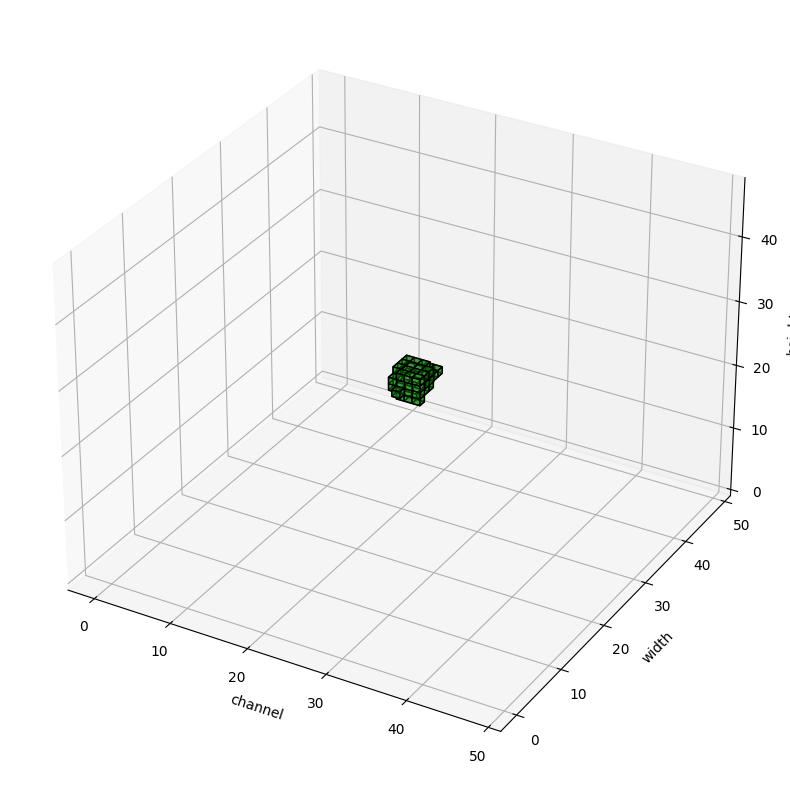

In [162]:
import matplotlib.pyplot as plt
import numpy as np

pred = pred.reshape(shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(np.where(pred > 0.5, 1, 0), color='r', edgecolor='k', alpha=0.5)
ax.voxels(np.where(data.y.argmax(dim=1).reshape(shape) > 0.5, 1, 0) , color='g', edgecolor='k', alpha=0.5)
ax.set(xlabel='channel', ylabel='width', zlabel='height')

plt.show()